In [1]:
import pandas as pd
import numpy as np
import pickle
from utilities import Mapping

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import rdkit
from rdkit import Chem
from rdkit.Chem import MACCSkeys

import re

import seaborn as sns
from matplotlib.colors import LogNorm
import math


In [3]:
data_path='data1.4/'
external_data_path='data-external/'

# Synergy score


## 1. Load data

Load synergy scores and link to study ID

In [4]:
summary=pd.read_csv(data_path+'summary_table_v1.4.csv')
#Block to StudyID mapping
source=pd.read_csv(data_path+'source.csv')

summary_study=pd.merge(summary, source[['block_id', 'study_id']], how='left',left_on='block_id', right_on='block_id')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
summary_study.head()

,block_id,drug_row,drug_col,cell_line_name,conc_r_unit,conc_c_unit,css,synergy_zip,synergy_bliss,synergy_loewe,synergy_hsa,ic50_row,ic50_col,ri_row,ri_col,css_row,css_col,S,study_id
0,1,5-FU,ABT-888,A2058,uM,uM,30.869,3.865915,6.256584,-2.951386,5.536903,5.126836,3.267734,11.471,-0.441,22.545,39.193,19.839,1
1,2,5-FU,ABT-888,A2058,uM,uM,27.460,8.247403,12.333896,3.125927,11.614215,5.126836,3.267734,11.471,-0.441,24.135,30.785,16.430,1
2,3,5-FU,ABT-888,A2058,uM,uM,29.901,6.063440,11.660209,2.452239,10.940528,5.126836,3.267734,11.471,-0.441,25.561,34.241,18.871,1
3,4,5-FU,ABT-888,A2058,uM,uM,24.016,-4.280231,5.145209,-4.062761,4.425528,5.126836,3.267734,11.471,-0.441,16.661,31.371,12.986,1
4,5,5-FU,AZD1775,A2058,uM,uM,66.847,12.284698,15.765467,10.409407,18.656340,5.126836,0.266027,11.471,25.164,76.501,57.193,30.212,1


Multiple experimental blocks are averaged

In [6]:
# take average of replicates experiments
summary_mean= summary_study.groupby(['drug_row','drug_col','cell_line_name', 'study_id'], as_index=False).mean()
summary_mean= summary_mean.loc[:, ['drug_row', 'drug_col', 'cell_line_name', 'study_id','ri_row', 'ri_col', 'synergy_loewe']]

In [7]:
summary_mean.head()

,drug_row,drug_col,cell_line_name,study_id,ri_row,ri_col,synergy_loewe
0,(+)-BICUCULLINE,TEMOZOLOMIDE,T98G,4,-21.0794,17.392589,4.436431
1,(+)-Blebbistatin,(+)-JQ1,TMD8,6,-20.0430,25.595000,-44.555935
2,(+)-Blebbistatin,IBRUTINIB (PCI-32765),TMD8,6,-9.7760,29.111000,-37.189720
3,(+)-JQ1,(+)-JQ1,RD,12,6.7970,6.964000,1.283298
4,(+)-JQ1,(+)-JQ1,SMS-CTR,12,11.5280,7.190000,-3.028745


## 2. Data exploratory analysis with visualization

Plot relative inhibition vs Loewe synergy 

In [8]:
sensitivity=pd.concat([summary_mean.loc[:, ['drug_row', 'cell_line_name', 'ri_row']].rename(columns={'drug_row':'drug', 'ri_row':'ri'}),
          summary_mean.loc[:, ['drug_col', 'cell_line_name', 'ri_col']].rename(columns={'drug_col':'drug', 'ri_col':'ri'})])


Text(0, 0.5, 'counts')

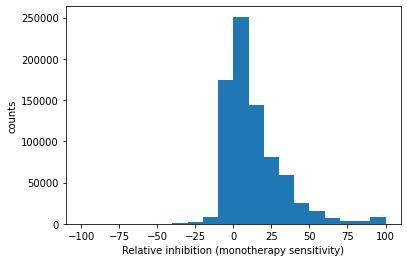

In [9]:
plt.hist(sensitivity['ri'], bins=20, range=[-100,100])
plt.xlabel("Relative inhibition (monotherapy sensitivity)")
plt.ylabel("counts")
#plt.savefig(data_path+'ri_cnt.png',  bbox_inches='tight', dpi=200)

Text(0, 0.5, 'counts')

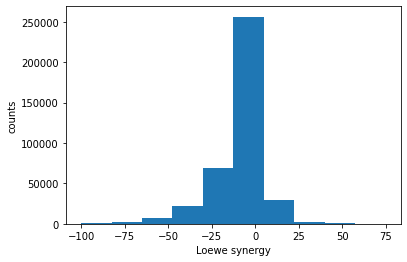

In [10]:
plt.hist(((summary_mean.loc[:,'synergy_loewe'].values.reshape(-1))), range=[-100, 75])
plt.xlabel("Loewe synergy")
plt.ylabel("counts")
#plt.savefig(data_path+'syn_cnt.png', bbox_inches='tight', dpi=200)

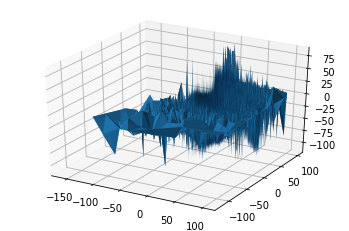

In [11]:
X=summary_mean.loc[:,'ri_row'].to_numpy()
Y=summary_mean.loc[:,'ri_col'].to_numpy()
Z=summary_mean.loc[:,'synergy_loewe'].to_numpy()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(X,Y,Z)

ax.set_xlabel('Drug1 relative inhibition')
ax.set_ylabel('Durg2 relative inhibition')
ax.set_zlabel('Synergy')
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
#fig.savefig(data_path+'ri_synergy_3d.png', dpi=200)

Transform items to ID

In [8]:
codes={'drugs': Mapping(set(summary_mean['drug_row'].unique()).union(set(summary_mean['drug_col'].unique()))),
      'cell':Mapping(summary_mean['cell_line_name'].unique())}

In [38]:
summary_mean['drug_col']=summary_mean['drug_col'].apply(lambda x: codes['drugs'].item2idx[x])
summary_mean['drug_row']=summary_mean['drug_row'].apply(lambda x: codes['drugs'].item2idx[x])
summary_mean['cell_line_name']=summary_mean['cell_line_name'].apply(lambda x: codes['cell'].item2idx[x])

In [10]:
summary_mean.head()

,drug_row,drug_col,cell_line_name,ri_row,ri_col,synergy_loewe
0,1433,4127,0,-21.0794,17.392589,4.436431
1,1998,2848,1,-20.0430,25.595000,-44.555935
2,1998,2720,1,-9.7760,29.111000,-37.189720
3,2848,2848,2,6.7970,6.964000,1.283298
4,2848,2848,3,11.5280,7.190000,-3.028745


In [40]:
summary_mean.to_pickle(data_path+'summary_mean.p')

# Drug's molescule structure

In [ ]:
#FILTERING and ERROR CORRECTION
drug=pd.read_csv(data_path+'drug.csv')
drug.drop('id', axis=1, inplace=True)
drug['id']=drug['dname'].apply(lambda x: codes['drugs'].item2idx.get(x))
drug=drug.loc[~drug['id'].isna(),:]

drug.loc[drug['cid']==57519530,'smiles']='CC(C)CC1C(=O)NC(C(=O)NC(CCCC=CCCCCCCC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)N1)CCCNC(=N)N)CC2=CNC3=CC=CC=C32)CC(C)C)CC(=O)N)(C)NC(=O)C(CC4=CC=CC=C4)NC(=O)C(C(C)O)NC(=O)C(CCC(=O)N)NC(=O)C(CCC(=O)N)NC(=O)C(CO)NC(=O)C(CCC(=O)N)NC(=O)CCNC(=O)C)(C)C(=O)NC(CCC(=O)N)C(=O)NC(CC(=O)N)C(=O)N)CC(C)C'
drug.loc[drug['cid']==73265323,'smiles']='CC(C)CCCCCCCC(=O)NC1C(C(C(OC1OC2=C3C=C4C=C2OC5=C(C=C(C=C5)C(C6C(=O)NC(C7=C(C(=CC(=C7)O)OC8C(C(C(C(O8)CO)O)O)O)C9=C(C=CC(=C9)C(C(=O)N6)NC(=O)C4NC(=O)C1C2=CC(=CC(=C2)OC2=C(C=CC(=C2)C(C(=O)NC(CC2=CC(=C(O3)C=C2)Cl)C(=O)N1)N)O)O)O)C(=O)O)OC1C(C(C(C(O1)CO)O)O)NC(=O)C)Cl)CO)O)O'
drug.loc[drug['cid']==16131923,'smiles']='CCCCCCCCCC(=O)NC1C(C(C(OC1OC2=C3C=C4C=C2OC5=C(C=C(C=C5)C(C6C(=O)NC(C7=C(C(=CC(=C7)O)OC8C(C(C(C(O8)CO)O)O)O)C9=C(C=CC(=C9)C(C(=O)N6)NC(=O)C4NC(=O)C1C2=CC(=CC(=C2)OC2=C(C=CC(=C2)C(C(=O)NC(CC2=CC(=C(O3)C=C2)Cl)C(=O)N1)N)O)O)O)C(=O)O)OC1C(C(C(C(O1)CO)O)O)NC(=O)C)Cl)CO)O)O'

drug.to_csv(data_path+'drug_clean.csv',index=False)

In [ ]:
#GET MACCS FINGERPRINT
drug=pd.read_csv(data_path+'drug_clean.csv')
drug['fps']=drug['smiles'].apply(lambda x: list(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x))) if Chem.MolFromSmiles(x) is not None else '')

drug.to_pickle(data_path+'drug_clean_fp.p')

In [30]:
drug=pickle.load(open(data_path+'drug_clean_fp.p', 'rb'))
drug['id']=drug['id'].apply(lambda x: int(x))

In [31]:
drug

,dname,chembl_id,inchikey,smiles,cid,molecular_formula,clinical_phase,cid_m,cid_s,stitch_name,drugbank_id,kegg_id,id,fps
0,5-FU,CHEMBL185,GHASVSINZRGABV-UHFFFAOYSA-N,C1=C(C(=O)NC(=O)N1)F,3385,C4H3FN2O2,4,CIDm00003385,CIDs00003385,5-fluorouracil,DB00544,D00584,2685,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ABT-888,CHEMBL506871,JNAHVYVRKWKWKQ-CYBMUJFWSA-N,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,11960529,C13H16N4O,3,CIDm11842604,CIDs11960529,veliparib,DB07232,D09692,3018,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,AZD1775,CHEMBL1976040,BKWJAKQVGHWELA-UHFFFAOYSA-N,CC(C)(C1=NC(=CC=C1)N2C3=NC(=NC=C3C(=O)N2CC=C)N...,24856436,C27H32N8O2,2,CIDm24856436,CIDs24856436,MK-1775,DB11740,NaN,307,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,BEZ-235,CHEMBL1879463,JOGKUKXHTYWRGZ-UHFFFAOYSA-N,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,11977753,C30H23N5O,2,CIDm11977753,CIDs11977753,NVP-BEZ235,DB11651,D10552,2217,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,BORTEZOMIB,CHEMBL325041,GXJABQQUPOEUTA-RDJZCZTQSA-N,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,387447,C19H25BN4O4,4,CIDm00093860,CIDs00387447,bortezomib,DB00188,D03150,3957,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4197,BMS-536924,CHEMBL401930,ZWVZORIKUNOTCS-OAQYLSRUSA-N,CC1=CC(=CC2=C1N=C(N2)C3=C(C=CNC3=O)NCC(C4=CC(=...,135440466,C25H26ClN5O3,0,NaN,NaN,NaN,NaN,NaN,111,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4198,56990-57-9,CHEMBL1208151,XGMFVZOKHBRUTL-UHFFFAOYSA-N,C1=CC2=C(C=C(C(=C2N=C1)O)N=NC3=CC4=C(C=C3)C=C(...,92577,C19H13N3O7S2,0,NaN,NaN,NaN,NaN,NaN,1750,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4199,405554-55-4,CHEMBL1891617,MLSAQOINCGAULQ-UHFFFAOYSA-N,CN(C)CCOC1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C...,135564599,C27H27N5O2,0,NaN,NaN,NaN,NaN,NaN,979,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4200,Talazoparib,CHEMBL3137320,HWGQMRYQVZSGDQ-HZPDHXFCSA-N,CN1C(=NC=N1)C2C(NC3=CC(=CC4=C3C2=NNC4=O)F)C5=C...,135565082,C19H14F2N6O,3,NaN,NaN,NaN,DB11760,NaN,4025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
#Convert SMILES's character into index
seqs=drug['smiles'].to_list()
chars=set([char for seq in seqs for char in seq])
chars = ['']+list(chars) #for zero embedding
codes['mole']=Mapping(chars)
drug['smiles']=drug['smiles'].apply(lambda x : [codes['mole'].item2idx[char] for char in x])


# Drug's target gene

In [15]:
#Merge target genes from DrugBank
drug_DrugBank_target=pd.read_csv(external_data_path+'drug/drug_DrugBank_target.csv')
drug_DrugBank_target=drug_DrugBank_target[['Gene', 'drugbank_id']].groupby('drugbank_id').agg(lambda x: set(x)).applymap(list).reset_index()
drug=pd.merge(drug, drug_DrugBank_target, how='left', on='drugbank_id')
drug.rename(columns={'Gene':'gene_drugbank'}, inplace=True)
drug['gene_drugbank']=drug['gene_drugbank'].apply(lambda x: [] if type(x) is float else x)

In [17]:
#Merge target genes from TTD
drug_TTD_target=pd.read_csv(external_data_path+'drug/drug_TTD_target.csv')
drug_TTD_target['TTD_TARGETS']=drug_TTD_target['TTD_TARGETS'].apply(lambda x: re.split(',|;', x))
drug=pd.merge(drug, drug_TTD_target.loc[:,['TTD_TARGETS', 'cid']],how='left', on='cid')
drug.rename(columns={'TTD_TARGETS':'gene_ttd'}, inplace=True)
drug['gene_ttd']=drug['gene_ttd'].apply(lambda x: [] if type(x) is float else x)


In [18]:
#Merge target genes from LINC
drug_lincs_target=pd.read_csv(external_data_path+'drug/drug_lincs_target.csv')
drug_lincs_target['target_genes']=drug_lincs_target['target_genes'].apply(lambda x: x.split(',') if type(x) is not float else [])
drug=pd.merge(drug, drug_lincs_target.loc[:, ['target_genes', 'cid']], how='left', on='cid')
drug.rename(columns={'target_genes':'gene_linc'}, inplace=True)

In [19]:
#Combine target genes 
drug['gene']=drug.apply(lambda row: list(set(row['gene_drugbank']+row['gene_ttd']+row['gene_linc'])), axis=1)

In [20]:
#Gene mapping
unique_genes_drug=[l for lst in drug['gene'].aggregate(list).values for l in lst]

# Cell line information

In [48]:
cell_line=pd.read_csv(data_path+'cell_line.csv')

In [49]:
# error correction
cell_line.replace({'large_intestine':'colon'}, inplace=True)

In [50]:
cell_line.drop('id',axis=1, inplace=True)
cell_line['cell_id']=cell_line['name'].apply(lambda x: codes['cell'].item2idx.get(x))

In [51]:
#subset of cell line features
cell_line_tissue = cell_line.loc[~cell_line['cell_id'].isna(), ['cell_id', 'tissue_name', 'disease_name']]
cell_line_tissue['cell_id']=cell_line_tissue['cell_id'].astype(int)
cell_line_tissue=cell_line_tissue.groupby('cell_id').first()

In [52]:
#tissue id to name mapping
codes['tissue']=Mapping(cell_line_tissue['tissue_name'].unique())
cell_line_tissue['tissue_name']=cell_line_tissue['tissue_name'].apply(lambda x: codes['tissue'].item2idx[x])
cell_line_tissue.rename(columns={'tissue_name':'tissue_id'}, inplace=True)

In [53]:
#disease id to name mapping
codes['disease']=Mapping(cell_line_tissue['disease_name'].apply(lambda x: x.split(' ')[-1].lower() if type(x) is not float else '').unique())
cell_line_tissue['disease_name']=cell_line_tissue['disease_name'].apply(lambda x: codes['disease'].item2idx[x.split(' ')[-1].lower()] if type(x) is not float else codes['disease'].item2idx[''])
cell_line_tissue.rename(columns={'disease_name':'disease_id'},inplace=True)

In [54]:
codes['tissue'].item2idx['haematopoietic_and_lymphoid']=1
codes['tissue'].idx2item[1]='hem&lymp'

In [55]:
codes['tissue'].item2idx

{'brain': 0,
 'haematopoietic_and_lymphoid': 1,
 'soft_tissue': 2,
 'bone': 3,
 'kidney': 4,
 'lung': 5,
 'breast': 6,
 'colon': 7,
 'prostate': 8,
 'ovary': 9,
 'skin': 10,
 'endometrium': 11,
 'pancreas': 12}

In [56]:
#disease name to id mapping
codes['disease'].item2idx

{'glioblastoma': 0,
 'lymphoma': 1,
 'rhabdomyosarcoma': 2,
 '': 3,
 'tumor': 4,
 'sarcoma': 5,
 'leukemia': 6,
 'carcinoma': 7,
 'adenocarcinoma': 8,
 'melanoma': 9,
 'myeloma': 10,
 'astrocytoma': 11,
 'gliosarcoma': 12,
 'cystadenocarcinoma': 13,
 'mesothelioma': 14}

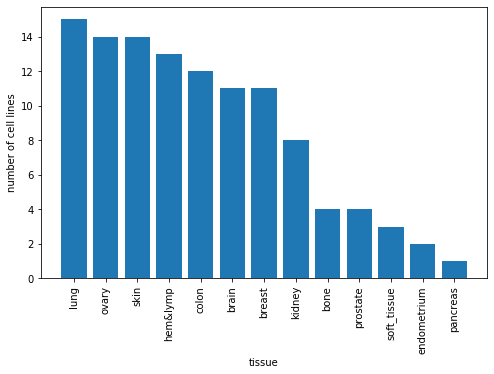

In [38]:
#Counting number of cell lines per tissue
tissue_cell_cnts=cell_line_tissue.groupby('tissue_id').count().sort_values(by='disease_id', ascending=False)['disease_id']
plt.figure(figsize=(8,5))
plt.bar([codes['tissue'].idx2item[tissue_id] for tissue_id in tissue_cell_cnts.index], tissue_cell_cnts)
plt.xticks(rotation=90)
plt.xlabel('tissue')
plt.ylabel('number of cell lines')
#plt.savefig(data_path+'tissue_num_cell.png', bbox_inches='tight', dpi=200)

# Cell line's gene expression

In [39]:
#Mapping
gene_identifiers=pd.read_csv(external_data_path+'cell/gene_identifiers_latest.csv')
cell_line_meta = pd.read_csv(external_data_path+'cell/cell_line_meta.csv')

_codes={}
_codes['gene_id2hgnc_symbol']=gene_identifiers[['gene_id', 'hgnc_symbol']].set_index('gene_id').to_dict('index')
_codes['SANGAR_ID2cell_name']=cell_line_meta.loc[cell_line_meta['name'].isin(codes['cell'].idx2item) & ~cell_line_meta['SANGAR_ID'].isna(), ['SANGAR_ID', 'name']].set_index('SANGAR_ID').to_dict('index')

In [40]:
#Broad institute
fpkm_broad=pd.read_csv(external_data_path+'cell/fpkm_broad.csv')

fpkm_broad=fpkm_broad.loc[fpkm_broad['model_id'].isin(_codes['SANGAR_ID2cell_name'])]#apply(lambda x: _codes['SANGAR_ID2cell_name'].get(x))
fpkm_broad['model_id']=fpkm_broad['model_id'].apply(lambda x: codes['cell'].item2idx[_codes['SANGAR_ID2cell_name'][x]['name']])
fpkm_broad.rename(columns={col:_codes['gene_id2hgnc_symbol'][col]['hgnc_symbol'] for col in fpkm_broad.columns[1:]}, inplace=True)

fpkm_broad.rename(columns={'model_id':'cell_id'}, inplace=True)
fpkm_broad.set_index('cell_id', inplace=True)


In [41]:
(fpkm_broad.sum()>0).sum()

21732

In [42]:
#Sangar
fpkm_sangar=pd.read_csv(external_data_path+'cell/fpkm_sangar.csv')

fpkm_sangar=fpkm_sangar.loc[fpkm_sangar['model_id'].isin(_codes['SANGAR_ID2cell_name'])]#apply(lambda x: _codes['SANGAR_ID2cell_name'].get(x))
fpkm_sangar['model_id']=fpkm_sangar['model_id'].apply(lambda x: codes['cell'].item2idx[_codes['SANGAR_ID2cell_name'][x]['name']])
fpkm_sangar.rename(columns={col:_codes['gene_id2hgnc_symbol'][col]['hgnc_symbol'] for col in fpkm_sangar.columns[1:]}, inplace=True)

fpkm_sangar.rename(columns={'model_id':'cell_id'}, inplace=True)
fpkm_sangar.set_index('cell_id', inplace=True)


In [43]:
(fpkm_sangar.sum()>0).sum()

18421

In [44]:
cell_gene_fpkm= pd.concat([fpkm_broad,fpkm_sangar], sort=True) #integrate BROAD and SANGAR
cell_gene_fpkm=cell_gene_fpkm.loc[:,(cell_gene_fpkm.std(skipna=True)!=0)] #drop genes with std=0
cell_gene_fpkm.fillna(0, inplace=True)

cell_gene_fpkm_norm=((cell_gene_fpkm-cell_gene_fpkm.mean())/cell_gene_fpkm.std()) #z-score, gene-wise

unique_genes_cell = cell_gene_fpkm_norm.columns.to_list()

In [45]:
len(unique_genes_cell)

22586

# Integrate all genes and save pickles

In [46]:
codes['gene']=Mapping(set(unique_genes_cell).union(set(unique_genes_drug)))

In [47]:
#number of unique genes
len(codes['gene'].idx2item)

24342

In [48]:
#Update drug's genes
drug['gene_id']=drug['gene'].apply(lambda genes: [codes['gene'].item2idx[gene] for gene in genes])
#subset of drug features
drug[['id', 'smiles', 'fps', 'gene_id']].groupby('id').first().to_pickle(data_path+'drug_features.p')

In [49]:
#Merge cell line's tissue, disease type with gene_id
cell_gene = cell_gene_fpkm_norm.apply(lambda row: {codes['gene'].item2idx[gene]:row[gene] for gene in cell_gene_fpkm_norm.columns}, axis=1).reset_index()
cell_gene.rename(columns={0:'gene_id'}, inplace=True)
cell_gene=cell_gene.groupby('cell_id').first()
cell_line = pd.merge(cell_line_tissue, cell_gene, how='left', on='cell_id')
cell_line['gene_id']=cell_line['gene_id'].apply(lambda x: {} if type(x) is float else x)

cell_line.to_pickle(data_path+'cell_features.p')

Now save codes book

In [50]:
pickle.dump(codes, open(data_path+'codes.p', 'wb'))

# Data exploratory analysis for cell lines

In [57]:
#Add cell line's tissue info into summary
summary_mean['tissue']=summary_mean['cell_line_name'].apply(lambda x: cell_line_tissue.loc[x, 'tissue_id'])

Plot number of blocks per cell line

Text(0, 0.5, 'number of blocks')

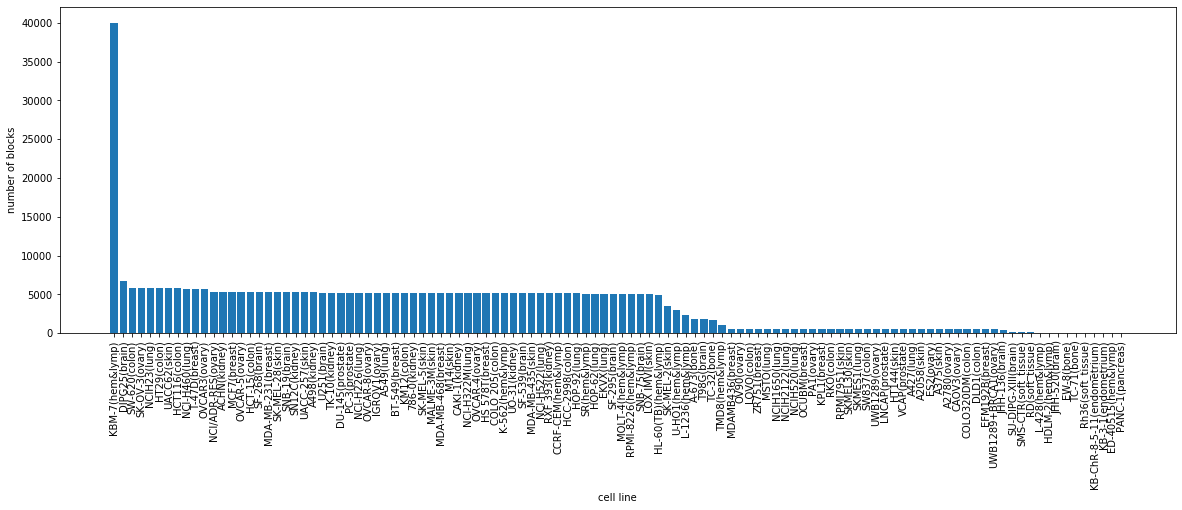

In [53]:
cell_line_exp=summary_mean.groupby('cell_line_name').count()['drug_row'].sort_values(ascending=False)

plt.figure(figsize=(20,6))
plt.bar([codes['cell'].idx2item[cell_id]
         +'('+codes['tissue'].idx2item[cell_line_tissue.loc[cell_id, 'tissue_id']]
         +')' for cell_id in cell_line_exp.index], cell_line_exp)
plt.xticks(rotation=90)
plt.xlabel('cell line')
plt.ylabel('number of blocks')

Plot number of blocks per tissue


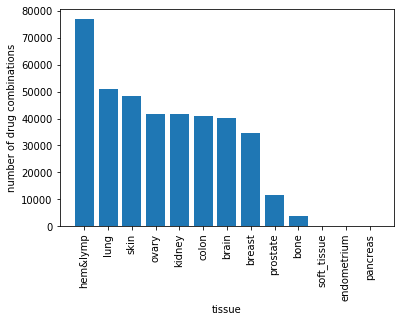

In [54]:
tissue_exp=summary_mean.groupby('tissue').count()['drug_row'].sort_values(ascending=False)

plt.bar([codes['tissue'].idx2item[tissue_id] for tissue_id in tissue_exp.index], tissue_exp)
plt.xticks(rotation=90)
plt.xlabel('tissue')
plt.ylabel('number of drug combinations')
#plt.savefig(data_path+'tissue_num_comb.png', bbox_inches='tight', dpi=200)

Plot number of blocks per study&tissue

In [184]:
study_ids=['', 'ONEIL','CLOUD','ALMANAC','FORCINA','NCATS_ATL','Mathews','NCATS_DIPG','NCATS_ES(FAKi/AURKi)','NCATS_ES(Nampt+PARP)','Wilson','NCATS_HL','Yohe','NCATS_2D_3D','Phelan','NCATS_MDR_CS','CCLE','CTRPv2','FIMM','gCSI','GDSC1','GRAY','UHNBreast','BEATAML'] #from study.csv
num_blocks=summary_mean.groupby(['study_id', 'tissue'], as_index=False)['drug_row'].count().rename(columns={'drug_row':'num_blocks'})
num_blocks['tissue']=num_blocks['tissue'].apply(lambda x: codes['tissue'].idx2item[x])
num_blocks['study_id']=num_blocks['study_id'].apply(lambda x: study_ids[x])

num_blocks_pivot=num_blocks.pivot("study_id", "tissue", "num_blocks").fillna(0)
num_blocks_pivot=num_blocks_pivot.loc[['ALMANAC', 'CLOUD', 'NCATS_HL', 'FORCINA','Mathews','Wilson','Yohe','NCATS_MDR_CS','Phelan','NCATS_ATL','NCATS_2D_3D',
                      'NCATS_DIPG', 'NCATS_ES(FAKi/AURKi)',
                      'NCATS_ES(Nampt+PARP)','ONEIL'],
                     ['brain','breast','colon','endometrium','hem&lymp','kidney','lung','ovary',
                     'bone','prostate']]


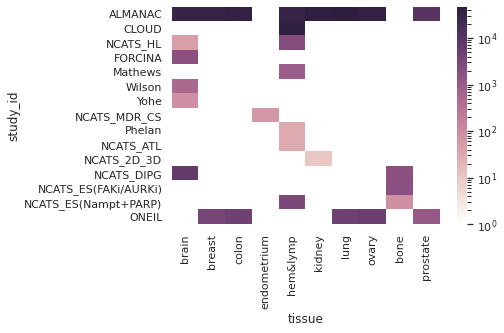

In [186]:
log_norm=LogNorm(vmin=num_blocks_pivot.min().min()+1, vmax=num_blocks_pivot.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(num_blocks_pivot.min().min()+1)), 1+math.ceil(math.log10(num_blocks_pivot.max().max())))]

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

ax=sns.heatmap(num_blocks_pivot.replace(0,1),
           norm=log_norm,
            cbar_kws={'ticks':cbar_ticks},
            cmap=cmap)

#fig=ax.get_figure()
#fig.tight_layout()
#fig.savefig(data_path+'study_heatmap.png', dpi=200)

Counts number of unique drugs for each tissue

In [55]:
#list unique drugs per tissue
tissue_drugs = pd.merge(summary_mean.groupby('tissue')['drug_row'].apply(set).reset_index(name='drug_row'),
         summary_mean.groupby('tissue')['drug_col'].apply(set).reset_index(name='drug_row'),
         on='tissue')
tissue_drugs['drugs']=tissue_drugs.apply(lambda row: row[1].union(row[2]), axis=1)
tissue_drugs.drop(['drug_row_x','drug_row_y'], axis=1, inplace=True)

In [56]:
tissue_drugs['num_drugs']=tissue_drugs['drugs'].apply(lambda x: len(x))
tissue_drugs.sort_values('num_drugs', ascending=False, inplace=True)

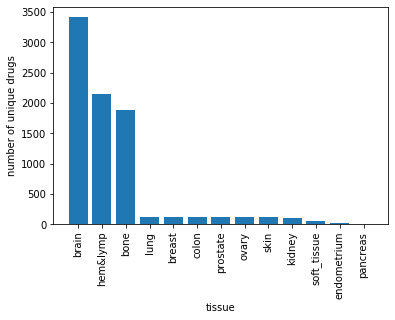

In [58]:
plt.bar([codes['tissue'].idx2item[tissue_id] for tissue_id in tissue_drugs['tissue']], tissue_drugs['num_drugs'])
plt.xticks(rotation=90)
plt.xlabel('tissue')
plt.ylabel('number of unique drugs')
#plt.savefig(data_path+'tissue_num_drugs.png', bbox_inches='tight', dpi=200)

Count number of shared drugs between tissues

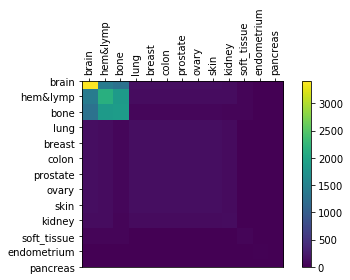

In [60]:
num_intersects=np.zeros((len(tissue_drugs),len(tissue_drugs)))
for i, tissue_id in enumerate(tissue_drugs['tissue']):    
    num_intersects[i,:]=tissue_drugs['drugs'].apply(lambda x: len(x.intersection(tissue_drugs.loc[tissue_id, 'drugs']))).values


fig,ax=plt.subplots()
im=ax.imshow(num_intersects)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_xticks(np.arange(len(tissue_drugs)))
ax.set_yticks(np.arange(len(tissue_drugs)))
ax.set_xticklabels([codes['tissue'].idx2item[tissue_id] for tissue_id in tissue_drugs['tissue']])
ax.set_yticklabels([codes['tissue'].idx2item[tissue_id] for tissue_id in tissue_drugs['tissue']])

fig.colorbar(im, ax=ax)

plt.setp(ax.get_xticklabels(), rotation=90)
#fig.tight_layout()
#plt.savefig(data_path+'heatmap.png', bb_inches='tight', dpi=200)